<a href="https://colab.research.google.com/github/luizgonzagasilva/kaggle-wids2022/blob/main/EXploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download conjunto de dados

In [4]:
!pip install kaggle

!mkdir .kaggle
!touch .kaggle/kaggle.json

api_token = {"username":"luizgonzagajunior","key":"374402bd0762f08f49a322b975e8c89f"}

import json
import zipfile
import os
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 /content/.kaggle/kaggle.json

mkdir: cannot create directory ‘.kaggle’: File exists


In [5]:
!rm /root/.kaggle/kaggle.json -f

In [6]:
!mv .kaggle /root/
!chmod 600 /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json

{"username": "luizgonzagajunior", "key": "374402bd0762f08f49a322b975e8c89f"}

In [7]:
!kaggle competitions download -c widsdatathon2022

  0% 0.00/1.65M [00:00<?, ?B/s]
100% 1.65M/1.65M [00:00<00:00, 55.7MB/s]
  0% 0.00/94.8k [00:00<?, ?B/s]
100% 94.8k/94.8k [00:00<00:00, 85.9MB/s]
  0% 0.00/157k [00:00<?, ?B/s]
100% 157k/157k [00:00<00:00, 137MB/s]


In [8]:
! ls -l

total 1948
drwxr-xr-x 1 root root    4096 Feb  1 14:32 sample_data
-rw-r--r-- 1 root root   97062 Feb 19 12:52 sample_solution.csv
-rw-r--r-- 1 root root  160497 Feb 19 12:52 test.csv.zip
-rw-r--r-- 1 root root 1726416 Feb 19 12:52 train.csv.zip


# Exploração

In [9]:
import pandas as pd
df = pd.read_csv('train.csv.zip')
df.shape

(75757, 64)

In [10]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [11]:
df['facility_type'] = df['facility_type'].apply(lambda x: x.split('_')[0])
df['facility_type'].value_counts()

Multifamily    39455
Office         13150
Education       5733
Warehouse       2879
Lodging         2847
2to4            1893
Commercial      1839
Retail          1437
5plus           1273
Public           990
Mixed            937
Nursing          772
Health           552
Grocery          448
Religious        399
Industrial       384
Parking          251
Service          215
Food             169
Laboratory       107
Data              27
Name: facility_type, dtype: int64

In [12]:
df['Year_Factor'].value_counts()

6    22449
5    18308
4    12946
3    10879
2     9058
1     2117
Name: Year_Factor, dtype: int64

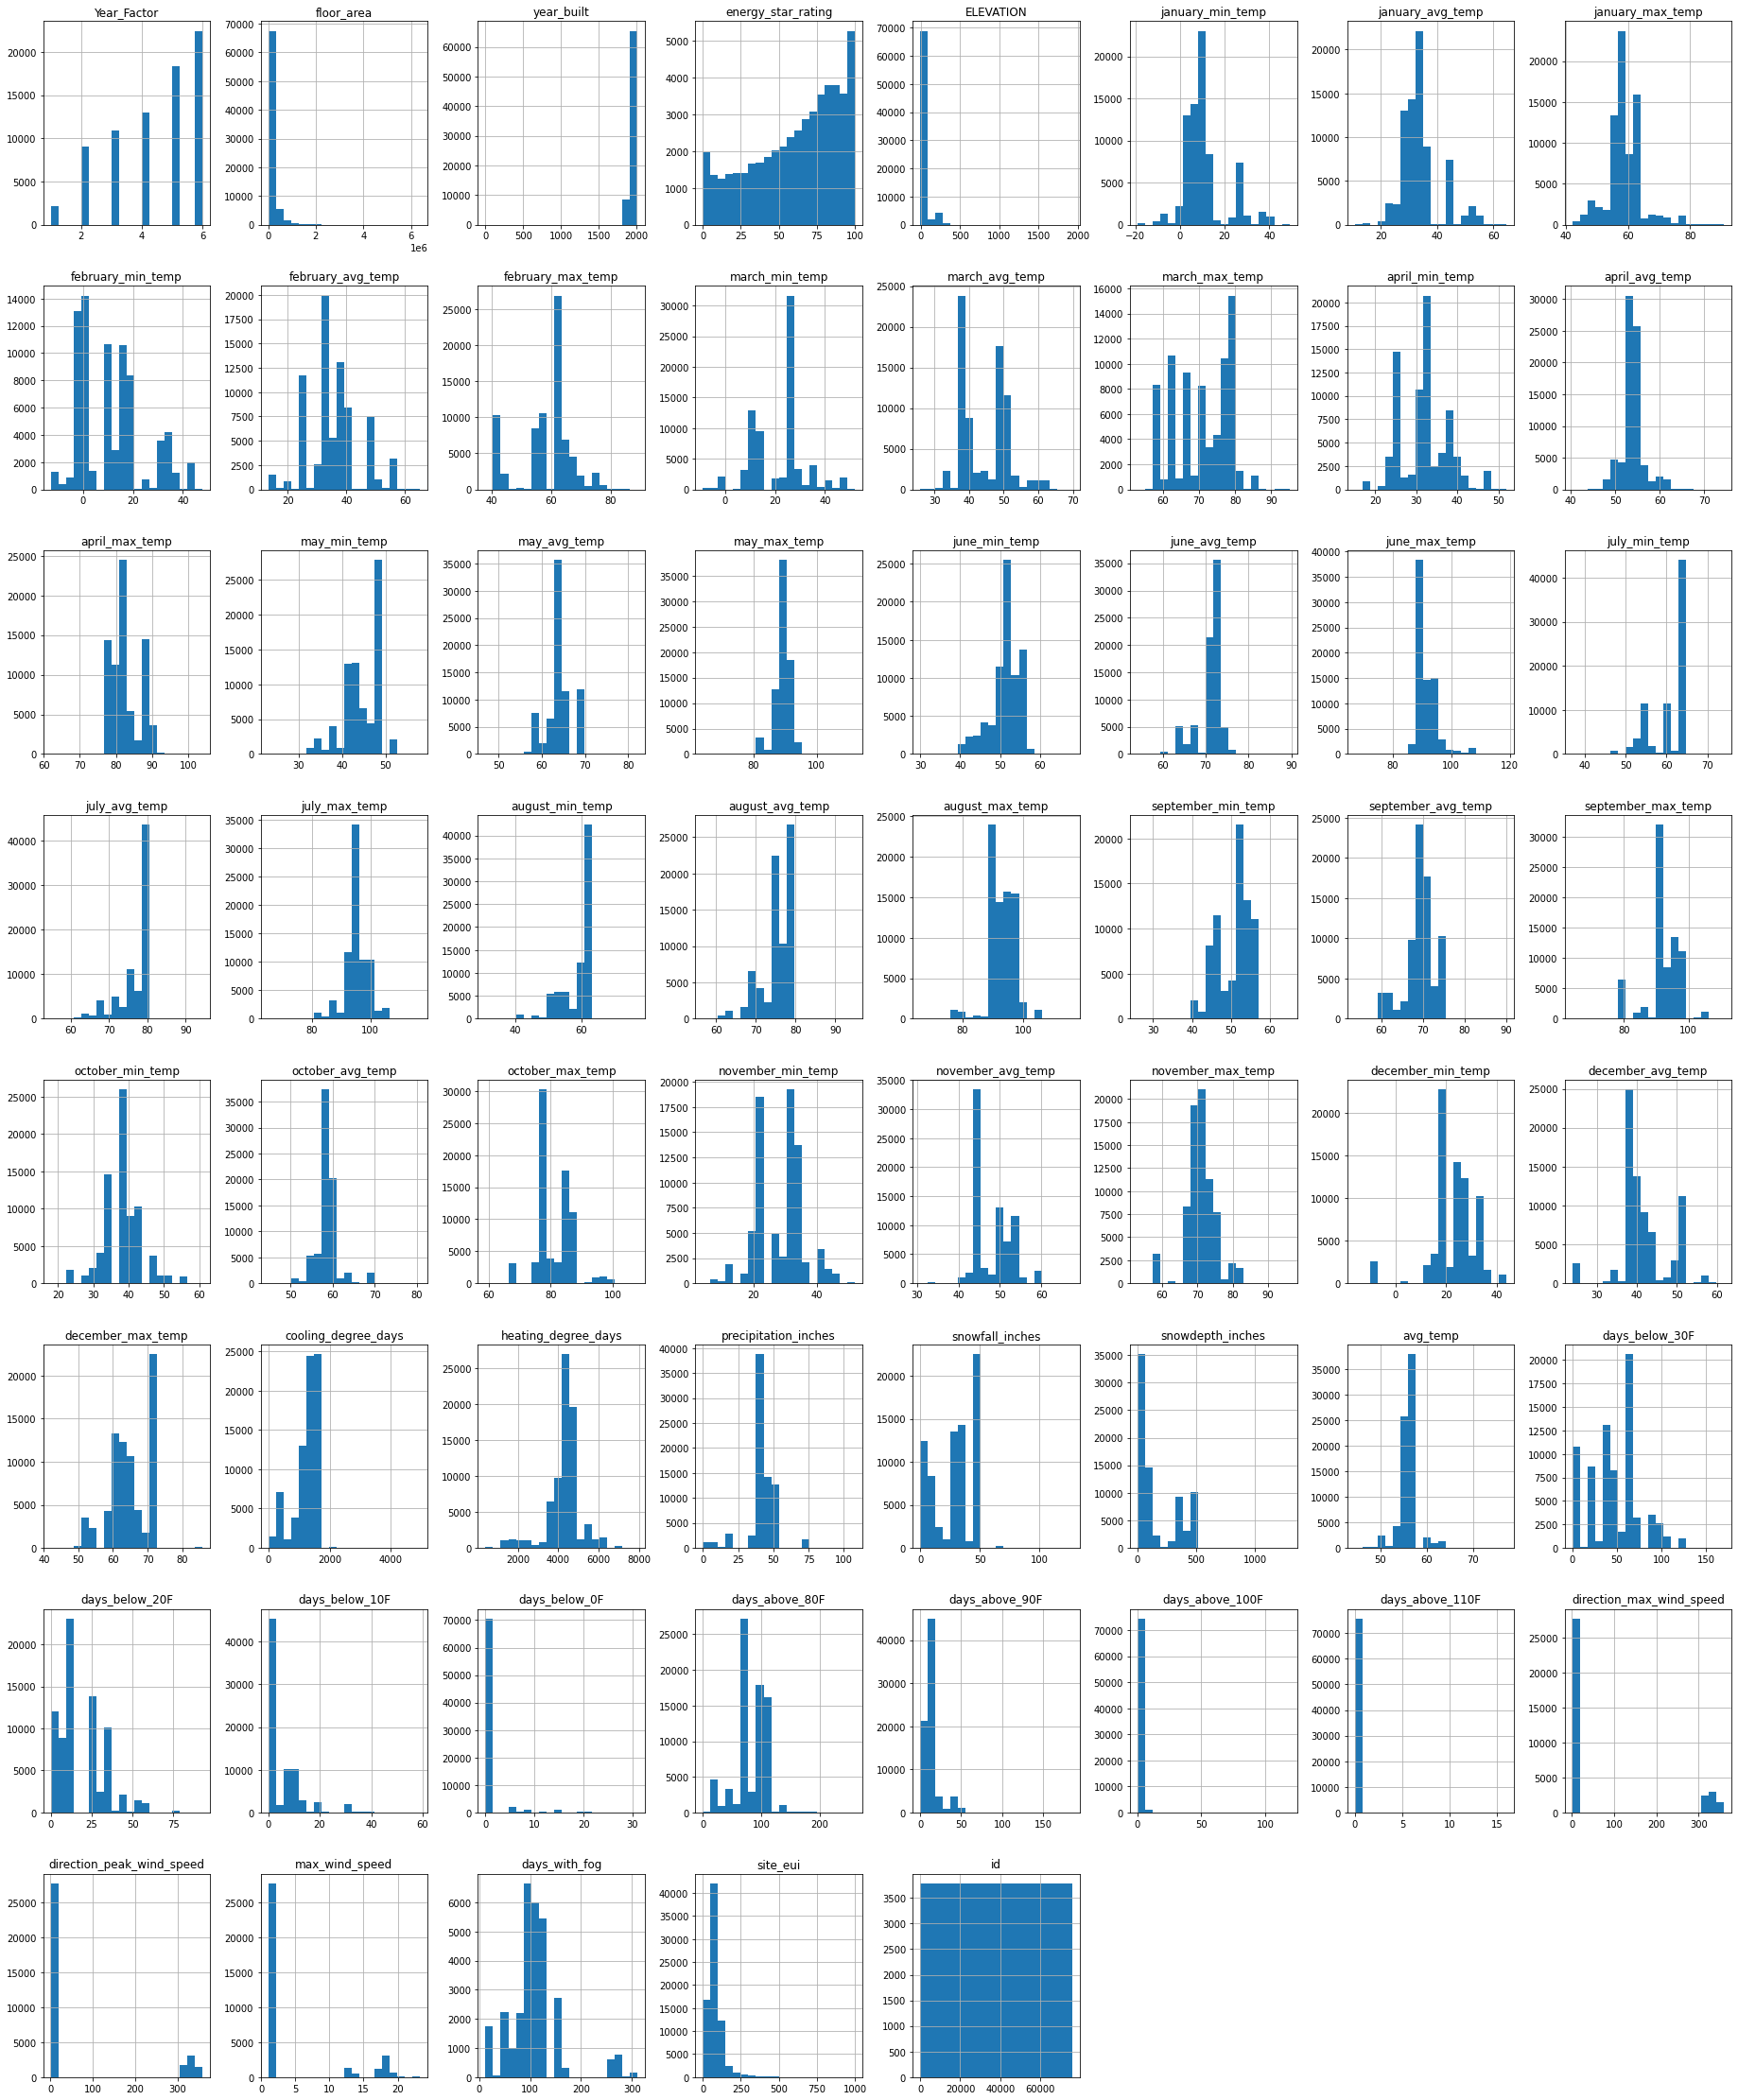

In [14]:
# distribuição das variáveis
_ = df.hist(figsize=[32,40], bins=20)

In [15]:
# somatoria de valores nulos
df.isnull().sum()

Year_Factor                      0
State_Factor                     0
building_class                   0
facility_type                    0
floor_area                       0
                             ...  
direction_peak_wind_speed    41811
max_wind_speed               41082
days_with_fog                45796
site_eui                         0
id                               0
Length: 64, dtype: int64

In [16]:
# somente valores nulos
df_null = pd.DataFrame(df.isnull().sum(), columns=['qtd_nulos']).reset_index()
df_null.loc[df_null['qtd_nulos']>0, :]

,index,qtd_nulos
5,year_built,1837
6,energy_star_rating,26709
58,direction_max_wind_speed,41082
59,direction_peak_wind_speed,41811
60,max_wind_speed,41082
61,days_with_fog,45796


In [17]:
indices = df_null.loc[df_null['qtd_nulos']>0, :]['index'].values
df[indices].head()

,year_built,energy_star_rating,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
0,1942.0,11.0,1.0,1.0,1.0,NaN
1,1955.0,45.0,1.0,NaN,1.0,12.0
2,1951.0,97.0,1.0,NaN,1.0,12.0
3,1980.0,46.0,1.0,NaN,1.0,12.0
4,1985.0,100.0,1.0,1.0,1.0,NaN


In [18]:
# considerando NaN dias sem neblina
df.loc[df['days_with_fog'].isnull(), 'days_with_fog']=0

# pela quantidade de Nan > 50% das amostras
df.drop(columns=['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed'], inplace=True, errors="ignore")

In [ ]:
# distribuição campos nulos
_ = df[indices].hist(figsize=[16,8])

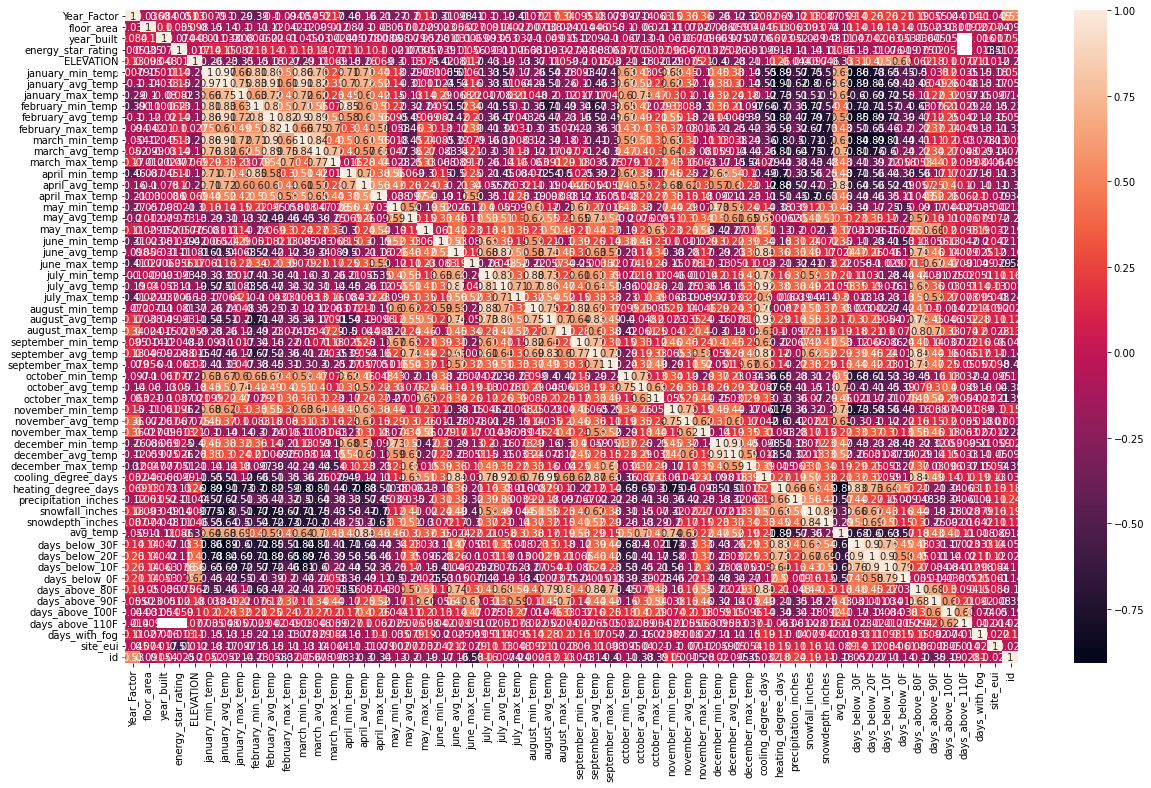

In [20]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Calculando a matriz de variâncias e covariâncias
corr = df.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [21]:
# as 5 variáveis mais correlacionadas com a variável target
top = corr['site_eui'].abs().sort_values(ascending=False).head(10)
top = top.sort_values()
top

march_avg_temp         0.135303
days_below_30F         0.139811
february_min_temp      0.147348
heating_degree_days    0.147861
february_avg_temp      0.154071
snowfall_inches        0.157284
january_avg_temp       0.167982
january_min_temp       0.179190
energy_star_rating     0.511012
site_eui               1.000000
Name: site_eui, dtype: float64

# Encoder e Normalização

In [164]:
# define vetor com os nomes das variaveis numericas e categoricas
var_categoricos = ['State_Factor','building_class','facility_type']
var_numericos = list(set(df.columns.values) - set(var_categoricos))

# remove identificador da construção
var_numericos.remove('id')

# remove variável alvo
var_numericos.remove('site_eui')

In [165]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer


# cria os pipelines
pip_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

pip_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder()),
    ('scaler', StandardScaler())])

# define as transformacoes no dados
transformacao = ColumnTransformer(
    transformers=[
        ('transformacao numerica', pip_numerico, var_numericos),
        ('transformacao categorica', pip_categorico, var_categoricos),        
    ])

# aplica as transformacoes
dados_transformados = transformacao.fit_transform(df[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados, df['site_eui']]
dados_transformados_com_classe.round(2)

array([[-2.7800e+00,  1.7200e+00, -1.4700e+00, ..., -1.1600e+00,
        -1.2700e+00,  2.4868e+02],
       [-2.7800e+00,  1.7200e+00, -1.4700e+00, ..., -1.1600e+00,
         2.0600e+00,  2.6500e+01],
       [-2.7800e+00,  1.7200e+00, -1.4700e+00, ..., -1.1600e+00,
         1.5900e+00,  2.4690e+01],
       ...,
       [-2.9300e+00, -6.0000e-02, -2.3700e+00, ..., -1.1600e+00,
        -2.2300e+00,  4.8400e+01],
       [-2.9300e+00, -6.0000e-02, -2.3700e+00, ..., -1.1600e+00,
        -2.2300e+00,  5.9202e+02],
       [-2.6900e+00,  1.8000e-01, -2.1400e+00, ...,  8.6000e-01,
        -2.7100e+00,  2.9150e+01]])

In [166]:
# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos
nomes.append("site_eui")

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,cooling_degree_days,february_max_temp,august_min_temp,october_max_temp,september_max_temp,days_below_20F,august_avg_temp,june_min_temp,february_min_temp,days_below_10F,days_above_100F,december_min_temp,days_with_fog,october_avg_temp,days_below_0F,july_min_temp,year_built,march_max_temp,july_max_temp,february_avg_temp,may_min_temp,november_min_temp,avg_temp,march_avg_temp,july_avg_temp,days_above_110F,june_avg_temp,december_max_temp,may_max_temp,january_avg_temp,heating_degree_days,april_max_temp,days_above_90F,Year_Factor,precipitation_inches,snowfall_inches,floor_area,january_min_temp,september_min_temp,june_max_temp,november_avg_temp,days_above_80F,august_max_temp,november_max_temp,ELEVATION,april_min_temp,october_min_temp,energy_star_rating,december_avg_temp,snowdepth_inches,april_avg_temp,may_avg_temp,march_min_temp,january_max_temp,days_below_30F,september_avg_temp,State_Factor,building_class,facility_type,site_eui
0,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.694356,1.623867,-0.302936,-2.052056,-0.281595,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.424272,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.611748,1.607036,1.725426,-2.170027,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,-1.274914,248.682615
1,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,0.073583,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,0.437535,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,-0.695842,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,2.062577,26.500150
2,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,-0.035703,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,0.461940,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,1.558795,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,1.585793,24.693619
3,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,0.756618,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.448240,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,-0.652483,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,-1.751698,48.406926
4,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.694356,1.623867,-0.302936,-2.052056,0.893224,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.404999,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.611748,1.607036,1.725426,1.688870,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,2.062577,3.899395


# Seleção de variáveis

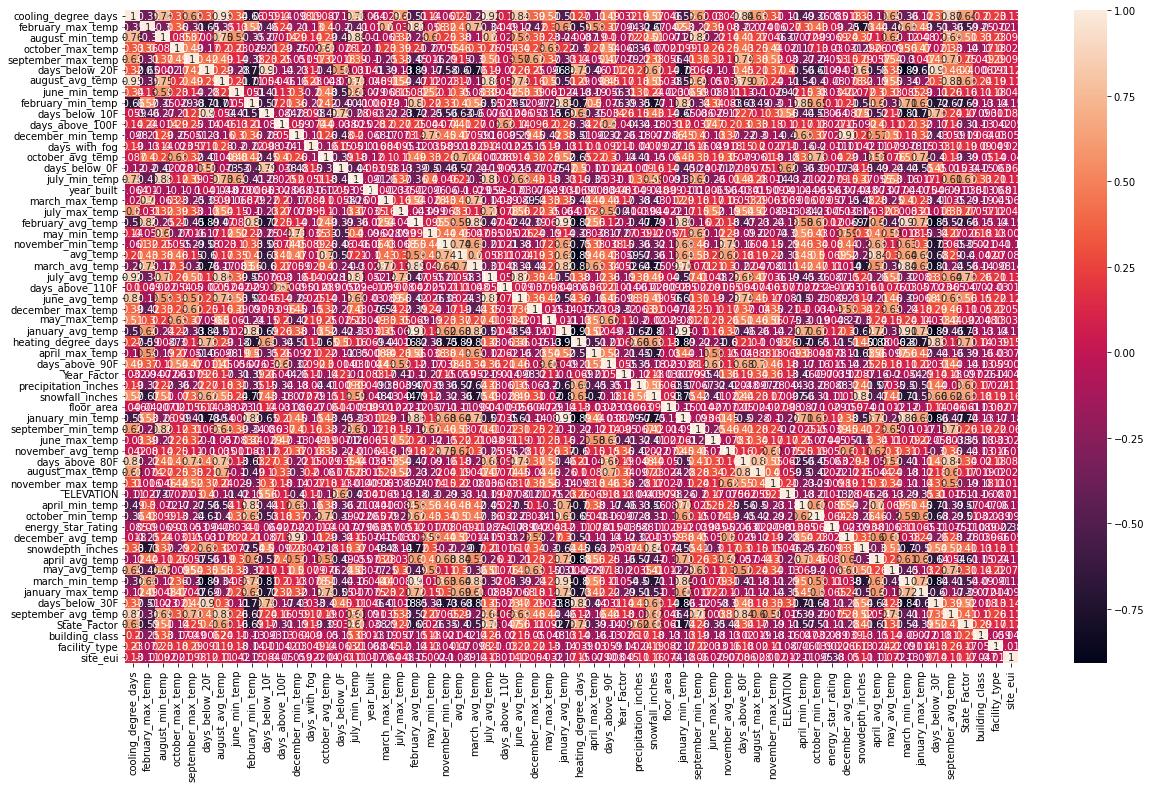

In [83]:
import seaborn as sns 
import matplotlib.pyplot as plt
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado.corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [84]:
# as 5 variáveis mais correlacionadas com a variável target
top = corr['site_eui'].abs().sort_values(ascending=False).head(20)
top = top.sort_values()
top

april_avg_temp          0.113008
snowdepth_inches        0.113371
precipitation_inches    0.113558
august_avg_temp         0.113786
days_below_20F          0.119492
june_avg_temp           0.122019
cooling_degree_days     0.125004
july_avg_temp           0.133856
march_min_temp          0.134110
march_avg_temp          0.135303
days_below_30F          0.139811
february_min_temp       0.147348
heating_degree_days     0.147861
february_avg_temp       0.154071
snowfall_inches         0.157284
State_Factor            0.165703
january_avg_temp        0.167982
january_min_temp        0.179190
energy_star_rating      0.379170
site_eui                1.000000
Name: site_eui, dtype: float64

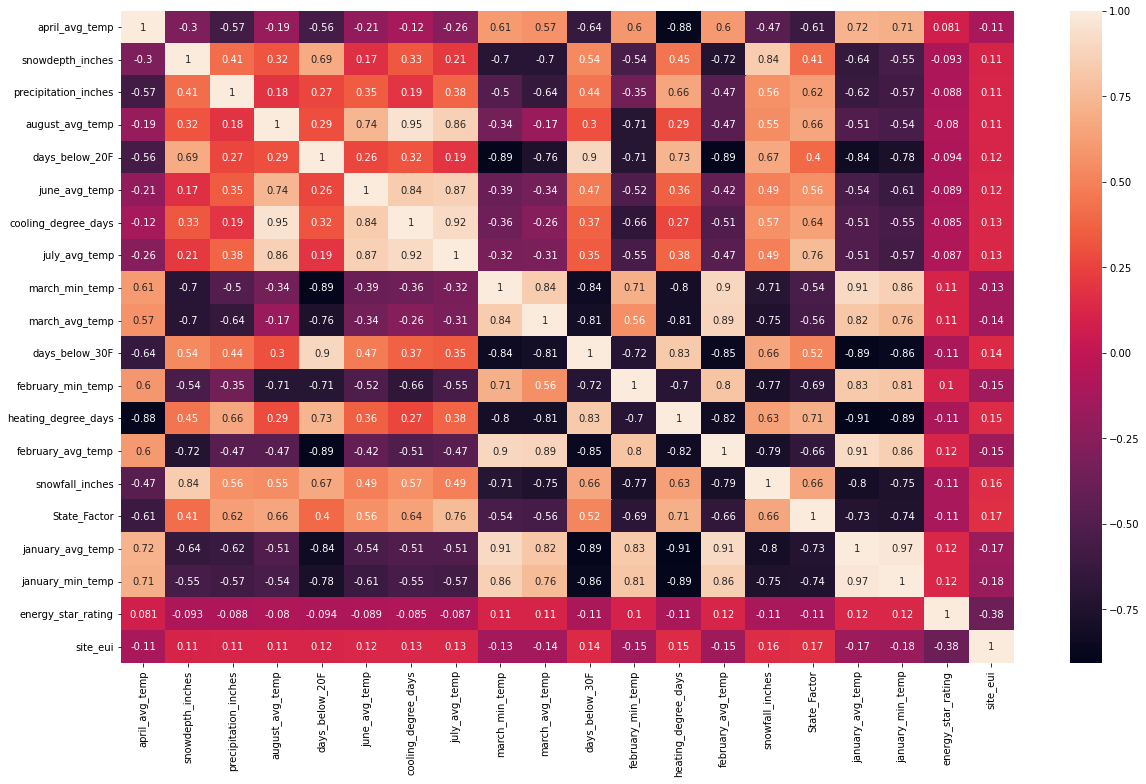

In [85]:
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado[top.index].corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

In [86]:
dataframe_processado.head()

,cooling_degree_days,february_max_temp,august_min_temp,october_max_temp,september_max_temp,days_below_20F,august_avg_temp,june_min_temp,february_min_temp,days_below_10F,days_above_100F,december_min_temp,days_with_fog,october_avg_temp,days_below_0F,july_min_temp,year_built,march_max_temp,july_max_temp,february_avg_temp,may_min_temp,november_min_temp,avg_temp,march_avg_temp,july_avg_temp,days_above_110F,june_avg_temp,december_max_temp,may_max_temp,january_avg_temp,heating_degree_days,april_max_temp,days_above_90F,Year_Factor,precipitation_inches,snowfall_inches,floor_area,january_min_temp,september_min_temp,june_max_temp,november_avg_temp,days_above_80F,august_max_temp,november_max_temp,ELEVATION,april_min_temp,october_min_temp,energy_star_rating,december_avg_temp,snowdepth_inches,april_avg_temp,may_avg_temp,march_min_temp,january_max_temp,days_below_30F,september_avg_temp,State_Factor,building_class,facility_type,site_eui
0,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.694356,1.623867,-0.302936,-2.052056,-0.281595,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.424272,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.611748,1.607036,1.725426,-2.170027,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,-1.274914,248.682615
1,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,0.073583,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,0.437535,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,-0.695842,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,2.062577,26.500150
2,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,-0.035703,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,0.461940,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,1.558795,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,1.585793,24.693619
3,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.501320,1.623867,-0.302936,-2.052056,0.756618,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.448240,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.621640,1.607036,1.725426,-0.652483,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,-1.751698,48.406926
4,-2.776721,1.724835,-1.466709,0.334141,-0.433216,-1.205856,-3.453236,-0.331322,1.850925,-0.69105,-0.124112,1.471405,-0.694356,1.623867,-0.302936,-2.052056,0.893224,1.185035,-2.77693,1.698778,0.308031,2.008837,0.355007,1.385627,-3.391255,-0.017181,-3.692394,1.074179,-1.741174,2.314092,-1.655776,-1.136779,-1.284612,-2.28876,-2.439607,-1.635885,-0.404999,2.618884,0.281601,-0.38853,1.38657,-2.717656,-1.829277,0.182378,-0.611748,1.607036,1.725426,1.688870,1.303147,-0.940595,0.68593,-2.466149,1.838593,1.670279,-1.767376,-1.372888,-2.735028,-1.163089,2.062577,3.899395


In [106]:
labels = ['facility_type','building_class','State_Factor','energy_star_rating','ELEVATION','floor_area','Year_Factor','avg_temp','year_built','days_with_fog','cooling_degree_days']

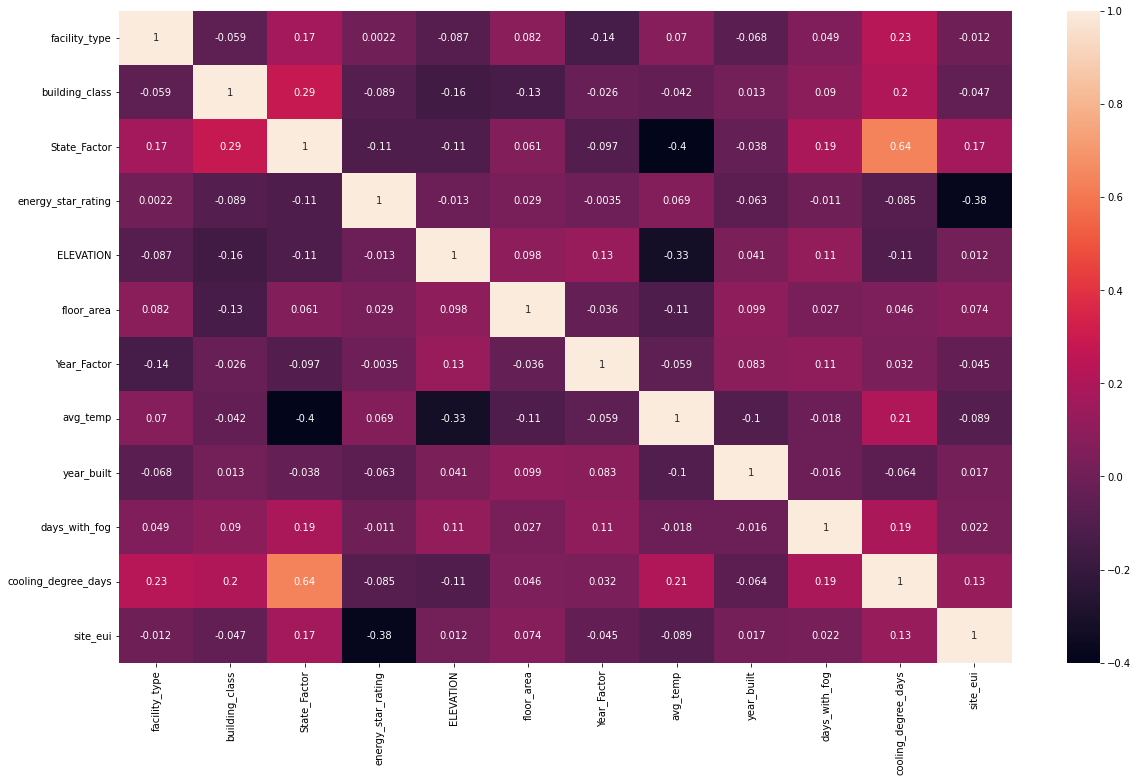

In [88]:
# Calculando a matriz de variâncias e covariâncias
corr = dataframe_processado[labels].corr(method = 'pearson')
f, ax = plt.subplots(figsize=(20, 12))

# Plotando o heatmap com a biblioteca seaborn
ax = sns.heatmap(corr, annot = True)

# Classificação

## Regressão linear

In [37]:
from sklearn.linear_model import LinearRegression

X = dataframe_processado[labels].drop(columns=['site_eui']).to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

lin = LinearRegression(fit_intercept=True)
lin.fit(X, y)

print(lin.coef_.round(2))
print(lin.score(X, y))

[ -3.64  -7.18   4.59 -21.68  -0.88   3.42  -3.07  -3.11  -0.4    0.24
   5.25]
0.1832204472739134


In [38]:
X = np.array([2, 3, 5, 6, 1, 4]).reshape(-1, 1)
y = [5, 10, 26, 37, 2, 17] # x^2 + 1

from sklearn.preprocessing import PolynomialFeatures
# Utilizando um polinomio de grau 2
p = PolynomialFeatures(degree=2)

X_Transf = p.fit_transform(X)
print(p.get_feature_names_out())
print(X_Transf)

['1' 'x0' 'x0^2']
[[ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  5. 25.]
 [ 1.  6. 36.]
 [ 1.  1.  1.]
 [ 1.  4. 16.]]


In [39]:
lin = LinearRegression(fit_intercept=True)
lin.fit(X_Transf, y)

LinearRegression()

In [40]:
lin.predict(X_Transf)

array([ 5., 10., 26., 37.,  2., 17.])

In [41]:
lin.score(X_Transf, y)

1.0

## Regresão linear com transformação

In [167]:
from sklearn.preprocessing import PolynomialFeatures

X = dataframe_processado[labels+['site_eui']].drop(columns=['site_eui']).to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

# Utilizando um polinomio de grau 2
p = PolynomialFeatures(degree=1)

X_Transf = p.fit_transform(X)
print(p.get_feature_names_out())
print(X_Transf)

['1' 'x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x6' 'x7' 'x8' 'x9' 'x10']
[[ 1.         -1.27491381 -1.16308853 ... -0.28159507 -0.69435626
  -2.7767205 ]
 [ 1.          2.06257696 -1.16308853 ...  0.07358294 -0.50132042
  -2.7767205 ]
 [ 1.          1.58579257 -1.16308853 ... -0.0357026  -0.50132042
  -2.7767205 ]
 ...
 [ 1.         -2.2284826  -1.16308853 ... -0.96462969 -0.69435626
  -2.92995404]
 [ 1.         -2.2284826  -1.16308853 ...  1.63090188 -0.69435626
  -2.92995404]
 [ 1.         -2.705267    0.85977978 ...  0.59268925 -0.69435626
  -2.69244206]]


In [168]:
from sklearn.linear_model import LinearRegression

# Note que nesse caso colocamos fit_intercept = False pois já capturamos o 
# termo idependente ao fazermos a transformação anterior
lin = LinearRegression(fit_intercept=False)
lin.fit(X_Transf, y)

#print(lin.coef_.round(2))
print(lin.score(X_Transf, y))

0.1832204472739134


In [169]:
lin.predict(X_Transf).mean()

82.58469263622118

In [170]:
y.mean()

82.5846926362212

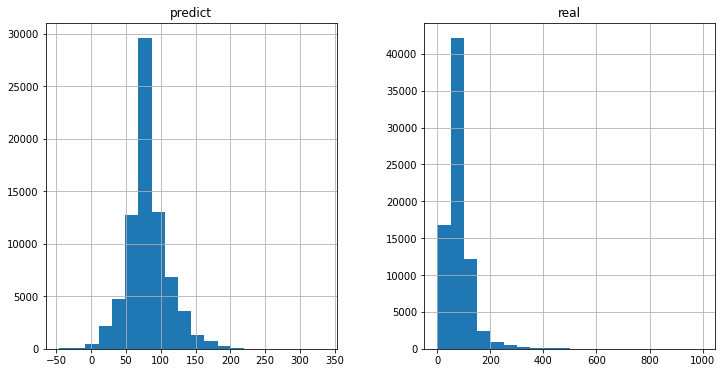

In [121]:
_ = pd.DataFrame(list(zip(lin.predict(X_Transf), y)), columns=['predict','real']).hist(figsize=[12,6], bins=20)

##  MLP

In [ ]:
dataframe_processado.shape

(75757, 60)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X = dataframe_processado.drop(columns=['site_eui']).to_numpy()
y = dataframe_processado['site_eui'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = MLPRegressor(hidden_layer_sizes=(59, 30, 15, ), activation='relu', alpha=0.0001, max_iter=5000)

regr.fit(X_train, y_train)
regr.score(X_train, y_train)

0.4793926208895808

In [ ]:
regr.score(X_test, y_test)

ValueError: ignored

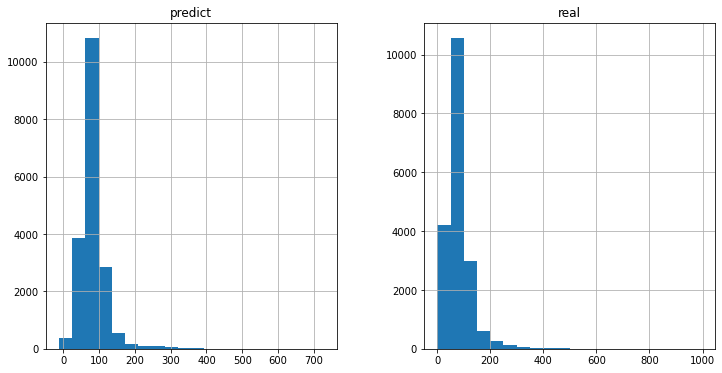

In [ ]:
#_ = pd.DataFrame(list(zip(regr.predict(X), y)), columns=['predict','real']).hist(figsize=[12,6], bins=20)

dict = {'predict': regr.predict(X_test), 'real': y_test}
_ = pd.DataFrame(dict).hist(figsize=[12,6], bins=20)

In [ ]:
dfs = dataframe_processado.sample(5000)
Xs = dfs.drop(columns=['site_eui']).to_numpy()
ys = dfs['site_eui'].to_numpy()

In [ ]:
from sklearn.neural_network import MLPRegressor
clf = MLPRegressor(hidden_layer_sizes=(60, 26, 13, 7, 3, ), max_iter=5000)

hyperparameter_space = {
    
  "activation": ['identity', 'logistic', 'tanh', 'relu'],
  "solver": ['lbfgs', 'sgd', 'adam'],
  "alpha": [0.001, 0.0001, 0.00001],
  "learning_rate":['constant','adaptive','invscaling'],
  "random_state": [1, 2, 3],
  "momentum": [0.4, 0.6, 0.9]

}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(clf, param_distributions=hyperparameter_space, 
                  scoring="explained_variance",
                  n_jobs=-1, cv=5, return_train_score=True)

rs.fit(Xs, ys)

print("Optimal hyperparameter combination:", rs.best_params_)
print()
print("Mean cross-validated training score:", rs.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the test scores are non-finite: [            nan             nan  8.95583666e-07 -1.42982412e-06
 -4.48748594e-11  1.62611667e-01 -3.60266367e-02  1.57520930e-01
  1.09679268e-01 -1.05670570e+01]
  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:972: UserWarning: One or more of the train scores are non-finite: [            nan             nan  5.97117648e-07 -1.39951097e-06
 -3.97445632e-11  1.92183428e-01  2.48722002e-01  1.93504836e-01
  2.18688138e-01  8.42910856e-01]
  category=UserWarning,


Optimal hyperparameter combination: {'solver': 'adam', 'random_state': 1, 'momentum': 0.9, 'learning_rate': 'adaptive', 'alpha': 1e-05, 'activation': 'identity'}

Mean cross-validated training score: 0.16261166680180644


In [ ]:
rs.best_estimator_.fit(X, y)
y_pred = rs.best_estimator_.predict(X) # Predictions

In [ ]:
rs.best_estimator_.score(X_test, y_test)

0.18314600821193272

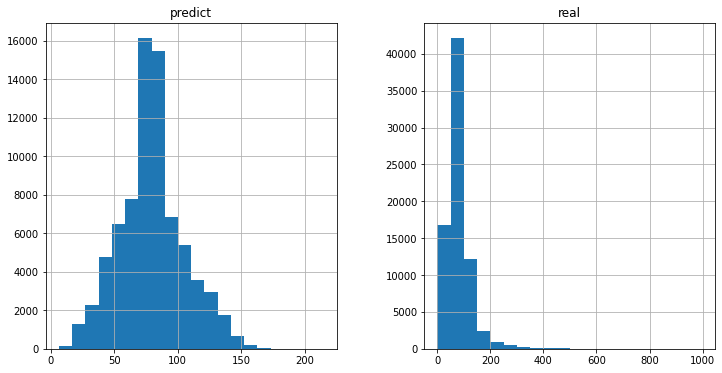

In [ ]:
dict = {'predict': y_pred, 'real': y}
_ = pd.DataFrame(dict).hist(figsize=[12,6], bins=20)

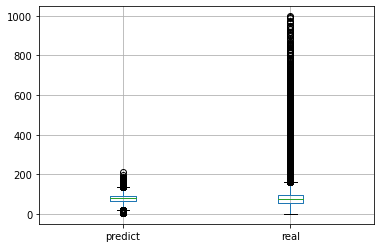

In [ ]:
_ = pd.DataFrame(dict).boxplot()

## LightGBM

In [ ]:
! pip install category_encoders
! pip install lightgbm

In [ ]:
df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery,61242.0,1942.0,11.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,0.0,248.682615,0
1,1,State_1,Commercial,Warehouse,274000.0,1955.0,45.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,12.0,26.500150,1
2,1,State_1,Commercial,Retail,280025.0,1951.0,97.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,12.0,24.693619,2
3,1,State_1,Commercial,Education,55325.0,1980.0,46.0,1.8,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse,66000.0,1985.0,100.0,2.4,36,50.5,68,35,50.589286,73,40,53.693548,80,41,55.5,78,46,56.854839,84,50,60.5,90,52,62.725806,84,52,62.16129,85,52,64.65,90,47,63.016129,83,43,53.8,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,0.0,3.899395,4


In [ ]:
def get_data_splits(dataframe, valid_fraction=0.1):
    #dataframe = dataframe.sort_values('DateSold')
    valid_size = int(len(dataframe) * valid_fraction)

    train = dataframe[:-valid_size * 2]
    # valid size == test size, last two sections of the data
    valid = dataframe[-valid_size * 2:-valid_size]
    test = dataframe[-valid_size:]
    
    return train, valid, test


train, valid, test = get_data_splits(df.drop(columns=['id']))

import category_encoders as ce
cb_enc = ce.CatBoostEncoder(cols=var_categoricos)

# Create the CatBoost encoder
cb_enc.fit(train[var_categoricos], train['site_eui'])

# Apply encoding to the train and validation sets as new columns
# Make sure to add `_cb` as a suffix to the new columns
train_encoded = train.join(cb_enc.transform(train[var_categoricos]).add_suffix('_cb'))
valid_encoded = valid.join(cb_enc.transform(valid[var_categoricos]).add_suffix('_cb'))
test_encoded  = test.join(cb_enc.transform(test[var_categoricos]).add_suffix('_cb'))

# remove categoricas originais
train_encoded = train_encoded.drop(var_categoricos, axis=1)
valid_encoded = valid_encoded.drop(var_categoricos, axis=1)
test_encoded  = test_encoded.drop(var_categoricos, axis=1)

# missing values
from sklearn.impute import SimpleImputer
my_imputer = SimpleImputer()

imputed_X_train = pd.DataFrame(my_imputer.fit_transform(train_encoded))
imputed_X_valid = pd.DataFrame(my_imputer.fit_transform(valid_encoded))
imputed_X_test  = pd.DataFrame(my_imputer.fit_transform(test_encoded))

imputed_X_train.columns = train_encoded.columns
imputed_X_valid.columns = valid_encoded.columns
imputed_X_test.columns  = test_encoded.columns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import lightgbm as lgb

feature_cols = imputed_X_train.columns.drop(['site_eui'])

dtrain = lgb.Dataset(imputed_X_train[feature_cols], label=train['site_eui'])
dvalid = lgb.Dataset(imputed_X_valid[feature_cols], label=valid['site_eui'])
dtest  = lgb.Dataset(imputed_X_test[feature_cols],  label=test['site_eui'])

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 36,
    'learning_rate': 0.0001,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.5,
    'bagging_freq': 3,
    'verbose': 0
}

bst = lgb.train(params, dtrain, num_boost_round=1000, valid_sets=dvalid, early_stopping_rounds=1000)

In [ ]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

ypred = bst.predict(imputed_X_test[feature_cols], num_iteration=bst.best_iteration)
print('The rmse of prediction is:', mean_squared_error(test['site_eui'], ypred) ** 0.5)

The rmse of prediction is: 67.00367109161208


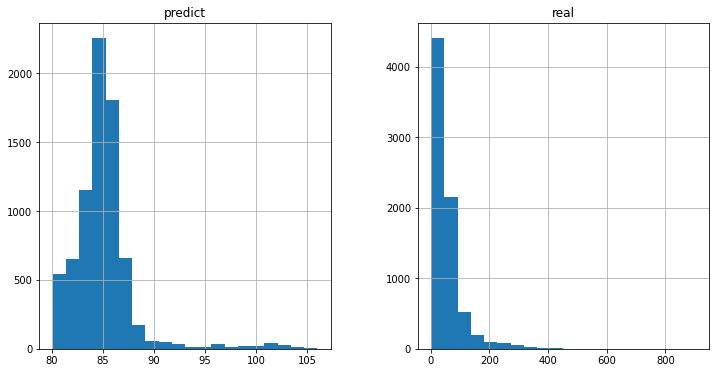

In [ ]:
_ = pd.DataFrame(list(zip(ypred, test['site_eui'])), columns=['predict','real']).hist(figsize=[12,6], bins=20)

# Submissão

In [171]:
import pandas as pd
df_sub = pd.read_csv('test.csv.zip')
df_sub.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.45,78,49,60.903226,87,51,63.15,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.05,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [172]:
# aplica as mesmas transformacoes nos dados de submissao
dados_transformados = transformacao.fit_transform(df_sub[var_categoricos + var_numericos])

# matrix esparça para densa
#dados_transformados = dados_transformados.todense()
dados_transformados_com_classe = np.c_[dados_transformados]
dados_transformados_com_classe.round(2)

# retornando a descrição dos atributos
nomes = []
nomes = nomes + var_numericos + var_categoricos

dataframe_processado = pd.DataFrame(data = dados_transformados_com_classe, columns=nomes)
dataframe_processado.head()

,cooling_degree_days,february_max_temp,august_min_temp,october_max_temp,september_max_temp,days_below_20F,august_avg_temp,june_min_temp,february_min_temp,days_below_10F,days_above_100F,december_min_temp,days_with_fog,october_avg_temp,days_below_0F,july_min_temp,year_built,march_max_temp,july_max_temp,february_avg_temp,may_min_temp,november_min_temp,avg_temp,march_avg_temp,july_avg_temp,days_above_110F,june_avg_temp,december_max_temp,may_max_temp,january_avg_temp,heating_degree_days,april_max_temp,days_above_90F,Year_Factor,precipitation_inches,snowfall_inches,floor_area,january_min_temp,september_min_temp,june_max_temp,november_avg_temp,days_above_80F,august_max_temp,november_max_temp,ELEVATION,april_min_temp,october_min_temp,energy_star_rating,december_avg_temp,snowdepth_inches,april_avg_temp,may_avg_temp,march_min_temp,january_max_temp,days_below_30F,september_avg_temp,State_Factor,building_class,facility_type
0,-0.865568,-0.147081,0.186769,1.624204,2.565423,-0.881922,-1.491969,1.4308,1.871769,-0.804544,2.906863,1.45149,-1.966722e-15,1.635641,-0.599846,-0.021704,0.757692,0.62324,-0.858626,2.323864,1.725789,2.097808,1.639641,2.114588,-1.330919,0.0,-0.901948,1.266556,-0.080714,1.99747,-2.104886,-0.042726,-0.530789,0.0,-2.324975,-0.92396,-0.513332,1.964985,1.552901,1.747362,2.117366,-1.222555,-1.401998,0.290288,-0.765952,1.906157,2.544421,-1.132239,1.950412,-0.525195,1.018998,0.634639,1.631945,0.679483,-1.283931,1.209536,-1.995206,-0.854911,-0.570711
1,-0.865568,-0.147081,0.186769,1.624204,2.565423,-0.881922,-1.491969,1.4308,1.871769,-0.804544,2.906863,1.45149,-1.966722e-15,1.635641,-0.599846,-0.021704,-0.054638,0.62324,-0.858626,2.323864,1.725789,2.097808,1.639641,2.114588,-1.330919,0.0,-0.901948,1.266556,-0.080714,1.99747,-2.104886,-0.042726,-0.530789,0.0,-2.324975,-0.92396,-0.538395,1.964985,1.552901,1.747362,2.117366,-1.222555,-1.401998,0.290288,-0.602438,1.906157,2.544421,-0.396831,1.950412,-0.525195,1.018998,0.634639,1.631945,0.679483,-1.283931,1.209536,-1.995206,-0.854911,-0.570711
2,-0.865568,-0.147081,0.186769,1.624204,2.565423,-0.881922,-1.491969,1.4308,1.871769,-0.804544,2.906863,1.45149,-1.966722e-15,1.635641,-0.599846,-0.021704,-0.325414,0.62324,-0.858626,2.323864,1.725789,2.097808,1.639641,2.114588,-1.330919,0.0,-0.901948,1.266556,-0.080714,1.99747,-2.104886,-0.042726,-0.530789,0.0,-2.324975,-0.92396,-0.560371,1.964985,1.552901,1.747362,2.117366,-1.222555,-1.401998,0.290288,-0.551836,1.906157,2.544421,-2.603054,1.950412,-0.525195,1.018998,0.634639,1.631945,0.679483,-1.283931,1.209536,-1.995206,-0.854911,-0.570711
3,-0.865568,-0.147081,0.186769,1.624204,2.565423,-0.881922,-1.491969,1.4308,1.871769,-0.804544,2.906863,1.45149,-1.966722e-15,1.635641,-0.599846,-0.021704,0.191523,0.62324,-0.858626,2.323864,1.725789,2.097808,1.639641,2.114588,-1.330919,0.0,-0.901948,1.266556,-0.080714,1.99747,-2.104886,-0.042726,-0.530789,0.0,-2.324975,-0.92396,-0.250673,1.964985,1.552901,1.747362,2.117366,-1.222555,-1.401998,0.290288,-0.641334,1.906157,2.544421,-1.254807,1.950412,-0.525195,1.018998,0.634639,1.631945,0.679483,-1.283931,1.209536,-1.995206,-0.854911,-0.570711
4,-0.865568,-0.147081,0.186769,1.624204,2.565423,-0.881922,-1.491969,1.4308,1.871769,-0.804544,2.906863,1.45149,-1.713000e+00,1.635641,-0.599846,-0.021704,-0.522343,0.62324,-0.858626,2.323864,1.725789,2.097808,1.639641,2.114588,-1.330919,0.0,-0.901948,1.266556,-0.080714,1.99747,-2.104886,-0.042726,-0.530789,0.0,-2.324975,-0.92396,-0.388522,1.964985,1.552901,1.747362,2.117366,-1.222555,-1.401998,0.290288,-0.768218,1.906157,2.544421,-1.213951,1.950412,-0.525195,1.018998,0.634639,1.631945,0.679483,-1.283931,1.209536,-1.995206,-0.854911,-0.570711


In [174]:
# regr.fit(X, y)

X = dataframe_processado[labels].to_numpy()
id = df_sub['id'].to_numpy()

#y_pred = regr.predict(X)
#y_pred = rs.best_estimator_.predict(X)

X_Transf = p.fit_transform(X)
y_pred = lin.predict(X_Transf)

# não existe gasto negativo
#y_pred[y_pred<0]=0

In [179]:
y.mean()

82.5846926362212

In [182]:
y_pred.mean()

82.58469263622119

In [183]:
df_submissao = pd.DataFrame(data=np.c_[id, y_pred.round(1)], columns=['id','site_eui'])
df_submissao['id'] = df_submissao['id'].astype(int)
df_submissao.to_csv('submissao.csv',index=False)

In [184]:
!kaggle competitions submit -c widsdatathon2022 -f submissao.csv -m "Linear Regression Poly(degree=1)"

100% 106k/106k [00:04<00:00, 26.9kB/s]
Successfully submitted to WiDS Datathon 2022